In [11]:
import requests
from bs4 import BeautifulSoup
import json
import re

def clean_text(text):
    # HTML 태그 제거
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # 특수 문자 제거 (예: 숫자, 기호 등)
    text = re.sub(r'[^가-힣\s]', '', text)  # 한글과 공백만 남김

    # 다중 공백 제거 및 양쪽 공백 Trim
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def remove_stopwords(text, stopwords):
    words = text.split()  # 문자열을 단어로 분리
    filtered_words = [word for word in words if word not in stopwords]  # 불용어 제거
    return ' '.join(filtered_words)  # 단어를 다시 문자열로 결합

# 불용어 리스트
stopwords = [
    '은', '는', '이', '가', '의', '에', '에서', '과', '와', '도', '로', 
    '아', '야', '한', '한테', '에게', '나', '너', '그', '그녀', '이', 
    '저', '우리', '그들', '당신', '이들', '그', '저', '이것', '저것', 
    '이런', '그런', '아무', '모든', '어떤', '누구', '어느', '왜', 
    '어떻게', '무엇', '뭐', '그러다', '하다', '있다', '없다', '되다', 
    '가다', '오다', '보다', '주다', 
    '오늘', '내일', '어제', '지금', '언제', '시간', '년', '월', '일',
    '그리고', '하지만', '또는', '그럼', '그래서', '즉', '그러나', '또한', '뿐만 아니라', '이외에도'
]

# 링크 가져오기
cursor = 0
links = []
for i in range(5):
    URL = f'https://news.naver.com/section/template/SECTION_ARTICLE_LIST?sid=100&sid2=&cluid=&date=&next={cursor}'
    response = requests.get(URL)
    i = response.json()
    text = i['renderedComponent']['SECTION_ARTICLE_LIST']
    soup = BeautifulSoup(text, 'html.parser')
    news_link = soup.select('.sa_text a[data-rank]')
    cursor = soup.select_one('div._PERSIST_META')['data-cursor']
    
    for link in news_link:
        href = link.get('href')  # href 속성 가져오기
        links.append(href)

# 제목과 본문을 JSON 형식으로 저장
articles = []
for j in links:
    response = requests.get(j) 
    soup = BeautifulSoup(response.text, 'html.parser')
    title = soup.select_one('h2.media_end_head_headline').text
    content = soup.select_one('article#dic_area').text.strip().replace("\n", '')
    
    # 본문 클렌징 적용
    cleaned_content = clean_text(content)
    
    # 불용어 제거 적용
    cleaned_content = remove_stopwords(cleaned_content, stopwords)
    
    # 기사 정보를 딕셔너리 형태로 저장
    article = {
        "제목": title,
        "내용": cleaned_content  # 클렌징 및 불용어 제거된 내용 저장
    }
    articles.append(article)

# JSON 파일로 저장
with open('news_articles2.json', 'w', encoding='utf-8') as json_file:
    json.dump(articles, json_file, ensure_ascii=False, indent=4)

print("뉴스 기사가 'news_articles2.json' 파일에 저장되었습니다.")


뉴스 기사가 'news_articles2.json' 파일에 저장되었습니다.


In [41]:
import json
import re
from gensim import corpora
from gensim.models import LdaModel
from pprint import pprint

# 불용어 리스트 정의
stop_words = [
    '은', '는', '이', '가', '의', '에', '에서', '과', '와', '도', '로',
    '아', '야', '한', '한테', '에게', '나', '너', '그', '그녀', '이',
    '저', '우리', '그들', '당신', '이들', '그', '저', '이것', '저것',
    '이런', '그런', '아무', '모든', '어떤', '누구', '어느', '왜',
    '어떻게', '무엇', '뭐', '그러다', '하다', '있다', '없다', '되다',
    '가다', '오다', '보다', '주다',
    '오늘', '내일', '어제', '지금', '언제', '시간', '년', '월', '일',
    '그리고', '하지만', '또는', '그럼', '그래서', '즉', '그러나', '또한', '뿐만 아니라', '이외에도',
    '윤건영', '전', '허', '있는', '수', '대표가', '대표는', '최', '김', '게', '안', '의원은', '좀', '것으로',
    '있다고', '것', '대한', '저는', '있다고', '이제', '를', '것으로', '등', '당', '이렇게'
]

# JSON 파일 로드
with open('news_articles2.json', 'r', encoding='utf-8') as json_file:
    articles = json.load(json_file)

# 문서 전처리
texts = []
for article in articles:
    # 내용에서 불용어 제거 및 토큰화
    tokens = article['내용'].split()
    tokens = [word for word in tokens if word not in stop_words]
    texts.append(tokens)

# 단어 사전 생성
dictionary = corpora.Dictionary(texts)

# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA 모델 학습 (주제를 1개로 설정)
lda_model = LdaModel(corpus, num_topics=1, id2word=dictionary, passes=15)

# 주제 출력
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)


(0, '0.005*"대통령" + 0.004*"윤" + 0.003*"경호처" + 0.003*"윤석열"')


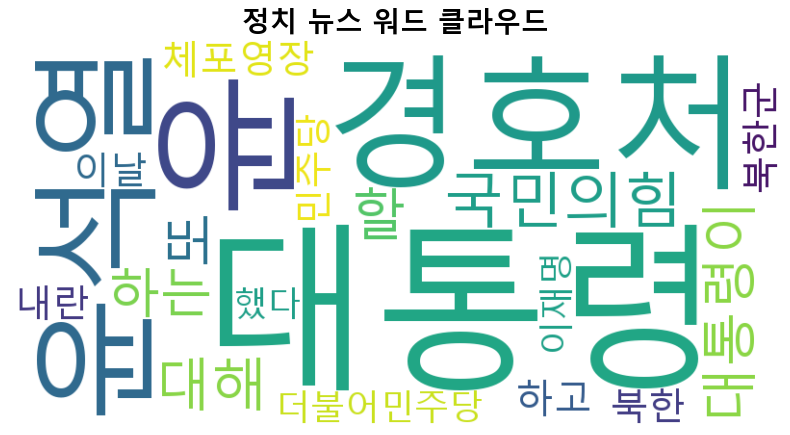

In [51]:
import json
import re
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 설정 (전역)
plt.rc('font', family='Malgun Gothic')
# 마이너스 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 불용어 리스트 정의
stop_words = [
    '은', '는', '이', '가', '의', '에', '에서', '과', '와', '도', '로',
    '아', '야', '한', '한테', '에게', '나', '너', '그', '그녀', '이',
    '저', '우리', '그들', '당신', '이들', '그', '저', '이것', '저것',
    '이런', '그런', '아무', '모든', '어떤', '누구', '어느', '왜',
    '어떻게', '무엇', '뭐', '그러다', '하다', '있다', '없다', '되다',
    '가다', '오다', '보다', '주다',
    '오늘', '내일', '어제', '지금', '언제', '시간', '년', '월', '일',
    '그리고', '하지만', '또는', '그럼', '그래서', '즉', '그러나', '또한', '뿐만 아니라', '이외에도',
    '윤건영', '전', '허', '있는', '수', '대표가', '대표는', '최', '김', '게', '안', '의원은', '좀', '것으로',
    '있다고', '것', '대한', '저는', '있다고', '이제', '를', '것으로', '등', '당', '이렇게'
]

# JSON 파일 로드
with open('news_articles2.json', 'r', encoding='utf-8') as json_file:
    articles = json.load(json_file)

# 문서 전처리
texts = []
for article in articles:
    # 내용에서 불용어 제거 및 토큰화
    tokens = article['내용'].split()
    tokens = [word for word in tokens if word not in stop_words]
    texts.append(tokens)

# 단어 사전 생성
dictionary = corpora.Dictionary(texts)

# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA 모델 학습 (주제를 1개로 설정)
lda_model = LdaModel(corpus, num_topics=1, id2word=dictionary, passes=15)

# 주제 가져오기
topic = lda_model.show_topic(0, topn=20)  # 주제 0의 상위 20개 단어
word_dict = dict(topic)  # 단어와 가중치 사전 생성

# 워드 클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,ㄴ
    background_color='white',
    font_path='C:/Windows/Fonts/malgun.ttf'  # Malgun Gothic 폰트 경로 설정
).generate_from_frequencies(word_dict)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 표시 제거
plt.title('정치 뉴스 워드 클라우드', fontdict={'fontsize': 20, 'fontweight': 'bold'})  # 제목 수정
plt.show()



In [52]:
import json
import re
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from pprint import pprint

# 불용어 리스트 정의
stop_words = [
    '은', '는', '이', '가', '의', '에', '에서', '과', '와', '도', '로',
    '아', '야', '한', '한테', '에게', '나', '너', '그', '그녀', '이',
    '저', '우리', '그들', '당신', '이들', '그', '저', '이것', '저것',
    '이런', '그런', '아무', '모든', '어떤', '누구', '어느', '왜',
    '어떻게', '무엇', '뭐', '그러다', '하다', '있다', '없다', '되다',
    '가다', '오다', '보다', '주다',
    '오늘', '내일', '어제', '지금', '언제', '시간', '년', '월', '일',
    '그리고', '하지만', '또는', '그럼', '그래서', '즉', '그러나', '또한', '뿐만 아니라', '이외에도',
    '윤건영', '전', '허', '있는', '수', '대표가', '대표는', '최', '김', '게', '안', '의원은', '좀', '것으로',
    '있다고', '것', '대한', '저는', '있다고', '이제', '를', '것으로', '등', '당', '이렇게'
]

# JSON 파일 로드
with open('news_articles2.json', 'r', encoding='utf-8') as json_file:
    articles = json.load(json_file)

# 문서 전처리
texts = []
for article in articles:
    # 내용에서 불용어 제거 및 토큰화
    tokens = article['내용'].split()
    tokens = [word for word in tokens if word not in stop_words]
    texts.append(tokens)

# 단어 사전 생성
dictionary = corpora.Dictionary(texts)

# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA 모델 학습 (주제를 1개로 설정)
lda_model = LdaModel(corpus, num_topics=1, id2word=dictionary, passes=15)

# Perplexity 계산
perplexity = lda_model.log_perplexity(corpus)
print(f'Perplexity: {perplexity}')

# Coherence Score 계산
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score}')

# 주제 출력
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)


Perplexity: -9.266492520508013
Coherence Score: 0.27974866232031725
(0, '0.005*"대통령" + 0.004*"윤" + 0.003*"경호처" + 0.003*"윤석열"')
